In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

# Load data 

The data used for the challenge consist of records from 12,000 ICU stays. All patients were adults who were admitted for a wide variety of reasons to cardiac, medical, surgical, and trauma ICUs. ICU stays of less than 48 hours have been excluded. Patients with DNR (do not resuscitate) or CMO (comfort measures only) directives were not excluded.

Four thousand records comprise training set A, and the remaining records form test sets B and C. Outcomes are provided for the training set records, and are withheld for the test set records.

Up to 42 variables were recorded at least once during the first 48 hours after admission to the ICU. Not all variables are available in all cases, however. Six of these variables are general descriptors (collected on admission), and the remainder are time series, for which multiple observations may be available.

Each observation has an associated time-stamp indicating the elapsed time of the observation since ICU admission in each case, in hours and minutes. Thus, for example, a time stamp of 35:19 means that the associated observation was made 35 hours and 19 minutes after the patient was admitted to the ICU.

Each record is stored as a comma-separated value (CSV) text file. To simplify downloading, participants may download a zip file or tarball containing all of training set A or test set B. Test set C will be used for validation only and will not be made available to participants.

In [2]:
#Load npy data

train = np.load('Data/P12Data_1/split_1/train_physionet2012_1.npy', allow_pickle=True)
test = np.load('Data/P12Data_1/split_1/test_physionet2012_1.npy', allow_pickle=True)
validation = np.load('Data/P12Data_1/split_1/validation_physionet2012_1.npy', allow_pickle=True)

# Inspecting the Data Structure

In [45]:
# Data shape
train.shape, test.shape, validation.shape

((9590,), (1199,), (1199,))

The train set consists of 9,590 records, where each record is a dictionary with various types of features, each represented by different arrays. Here’s an overview of each feature and its structure:

### Features Overview:

1. **`ts_values`**: 
   - **Type**: Array of shape `(x, 37)`, where `x` is the number of time steps recorded for that patient.
   - **Description**: Each time step contains values for 37 different variables (e.g., vital signs, lab results). These variables represent various health indicators, recorded in chronological order.
   - **Details**: 
     - **Observation Frequency**: Variables may be observed once, multiple times, or not at all, depending on the patient’s condition and treatment requirements.
     - **Recording Intervals**: Observations are logged at both regular intervals (hourly or daily) and irregular intervals (based on clinical need).
     - **Variable Availability**: Not all 37 variables are available for every patient at every time step.
     - **Outliers**: Some records may contain outliers or duplicate measurements (especially for metrics like blood pressure, where multiple sensors/methods are used).

2. **`ts_indicators`**: 
   - **Type**: Array of shape `(x, 37)`, with boolean values.
   - **Description**: A corresponding indicator array for `ts_values` that flags missing data (`True` for present values, `False` for missing). It provides information on data availability for each variable at each time step.

3. **`ts_time`**: 
   - **Type**: Array of length `x`.
   - **Description**: This array captures the time elapsed since ICU admission for each recorded time step in `ts_values`. It helps to align the time series data with each patient’s ICU stay duration.

4. **`static`**: 
   - **Type**: Array of length 6.
   - **Description**: Static patient information, collected upon ICU admission and recorded with a timestamp of `00:00`.
   - **Details**:
     - **RecordID**: A unique integer identifier for each ICU stay.
     - **Age**: Patient's age in years.
     - **Gender**: Binary indicator (0 for female, 1 for male).
     - **Height**: Patient’s height in centimeters.
     - **ICUType**: Type of ICU (1 for Coronary Care Unit, 2 for Cardiac Surgery Recovery Unit, 3 for Medical ICU, 4 for Surgical ICU).
     - **Weight**: Patient’s weight in kilograms.

5. **`labels`**: 
   - **Type**: Integer, `0` or `1`.
   - **Description**: Outcome label indicating whether the patient survived (0) or died in-hospital (1).

### Additional Notes:

- **Temporal and Static Data**: `ts_values`, `ts_indicators`, and `ts_time` collectively represent the time-series data collected during the patient’s ICU stay, while `static` represents admission data.
- **Variable Variability**: `ts_values` variables have different recording patterns and may reflect irregularities such as outliers, missing values, or duplicated entries.
- **Outcome Focus**: The target variable (`labels`) represents the critical outcome of in-hospital mortality, useful for predictive modeling.

In [63]:
# 1. General structure
print("Total samples:", len(train))
print("Keys in each sample:", train[0].keys())

Total samples: 9590
Keys in each sample: dict_keys(['ts_values', 'ts_indicators', 'ts_times', 'static', 'labels'])


In [26]:
# Check basic information
sample = train[0]
print("Keys in each sample:", sample.keys())
print("Shape of ts_values:", sample['ts_values'].shape)
print("Shape of indicators:", sample['ts_indicators'].shape)
print("Shape of ts_times:", sample['ts_times'].shape)
print("Shape of static:", sample['static'].shape)
print("Label:", type(sample['labels']))

Keys in each sample: dict_keys(['ts_values', 'ts_indicators', 'ts_times', 'static', 'labels'])
Shape of ts_values: (74, 37)
Shape of indicators: (74, 37)
Shape of ts_times: (74,)
Shape of static: (8,)
Label: <class 'numpy.int64'>


In [65]:
# 2. Consistency checks on shapes
ts_values_shapes = [sample['ts_values'].shape for sample in train]
ts_indicators_shapes = [sample['ts_indicators'].shape for sample in train]
ts_times_shapes = [sample['ts_times'].shape for sample in train]
static_shapes = [sample['static'].shape for sample in train]
print("Unique shapes of ts_values across samples:", set(ts_values_shapes))
print("Unique shapes of ts_indicators across samples:", set(ts_indicators_shapes))
print("Unique shapes of ts_times across samples:", set(ts_times_shapes))
print("Unique shapes of static features:", set(static_shapes))

Unique shapes of ts_values across samples: {(43, 37), (98, 37), (164, 37), (160, 37), (56, 37), (45, 37), (111, 37), (100, 37), (34, 37), (21, 37), (155, 37), (5, 37), (60, 37), (126, 37), (113, 37), (7, 37), (18, 37), (73, 37), (62, 37), (117, 37), (139, 37), (128, 37), (183, 37), (22, 37), (77, 37), (143, 37), (75, 37), (130, 37), (13, 37), (11, 37), (79, 37), (90, 37), (101, 37), (156, 37), (35, 37), (24, 37), (145, 37), (39, 37), (92, 37), (158, 37), (52, 37), (41, 37), (107, 37), (96, 37), (118, 37), (162, 37), (1, 37), (122, 37), (54, 37), (120, 37), (109, 37), (14, 37), (3, 37), (80, 37), (69, 37), (58, 37), (124, 37), (135, 37), (190, 37), (82, 37), (71, 37), (137, 37), (203, 37), (31, 37), (20, 37), (86, 37), (97, 37), (152, 37), (141, 37), (207, 37), (44, 37), (9, 37), (88, 37), (99, 37), (165, 37), (33, 37), (154, 37), (48, 37), (103, 37), (114, 37), (94, 37), (50, 37), (61, 37), (116, 37), (105, 37), (127, 37), (37, 37), (171, 37), (10, 37), (65, 37), (76, 37), (131, 37), (

## Visualization of ts_values features

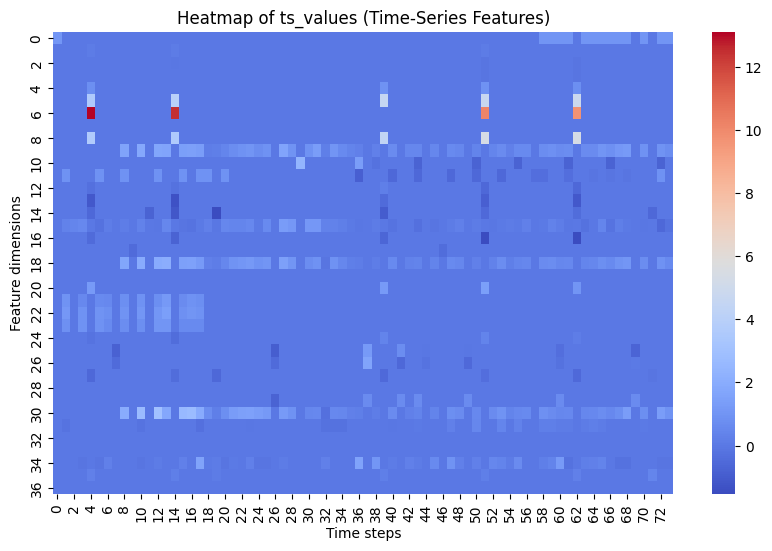

In [27]:
# ts_values analysis
ts_values = sample['ts_values']
plt.figure(figsize=(10, 6))
sns.heatmap(ts_values.T, cmap='coolwarm', cbar=True)
plt.title("Heatmap of ts_values (Time-Series Features)")
plt.xlabel("Time steps")
plt.ylabel("Feature dimensions")
plt.show()

Basic Statistics for Each Feature:
       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
count  74.000000  74.000000  74.000000  74.000000  74.000000  74.000000   
mean    0.191250   0.002717  -0.004483  -0.003931   0.045946   0.292769   
std     0.398654   0.016424   0.022169   0.020804   0.194346   1.101734   
min     0.000000  -0.035741  -0.131791  -0.126485   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
max     1.048501   0.091884   0.000000   0.000000   0.926499   4.828999   

       Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_27  \
count  74.000000       74.0  74.000000  74.000000  ...   74.000000   
mean    0.614052        0.0   0.300625   0.553594  ...   -0.041993   
std     2.608543        0.0   1.142558   0.522025  ...    0.139392   
min     0

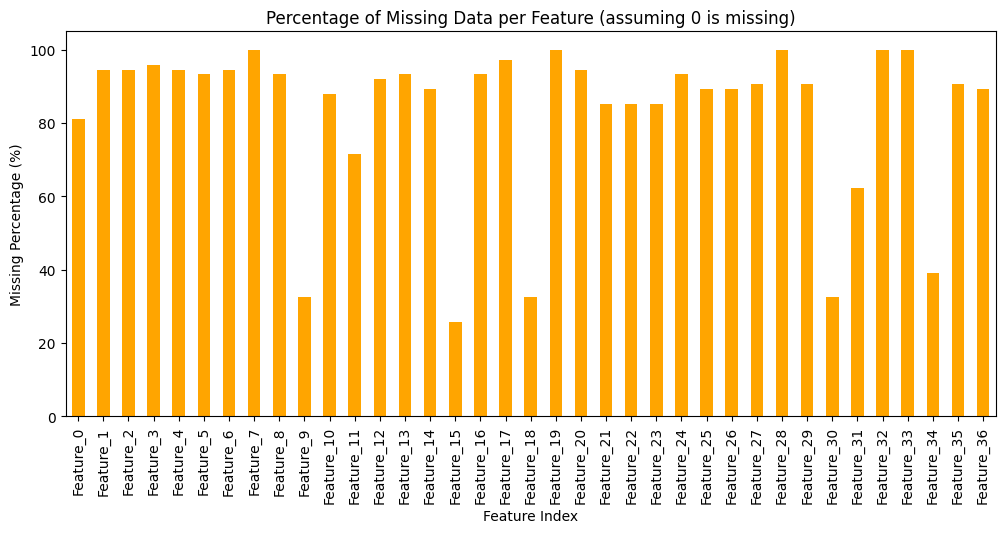

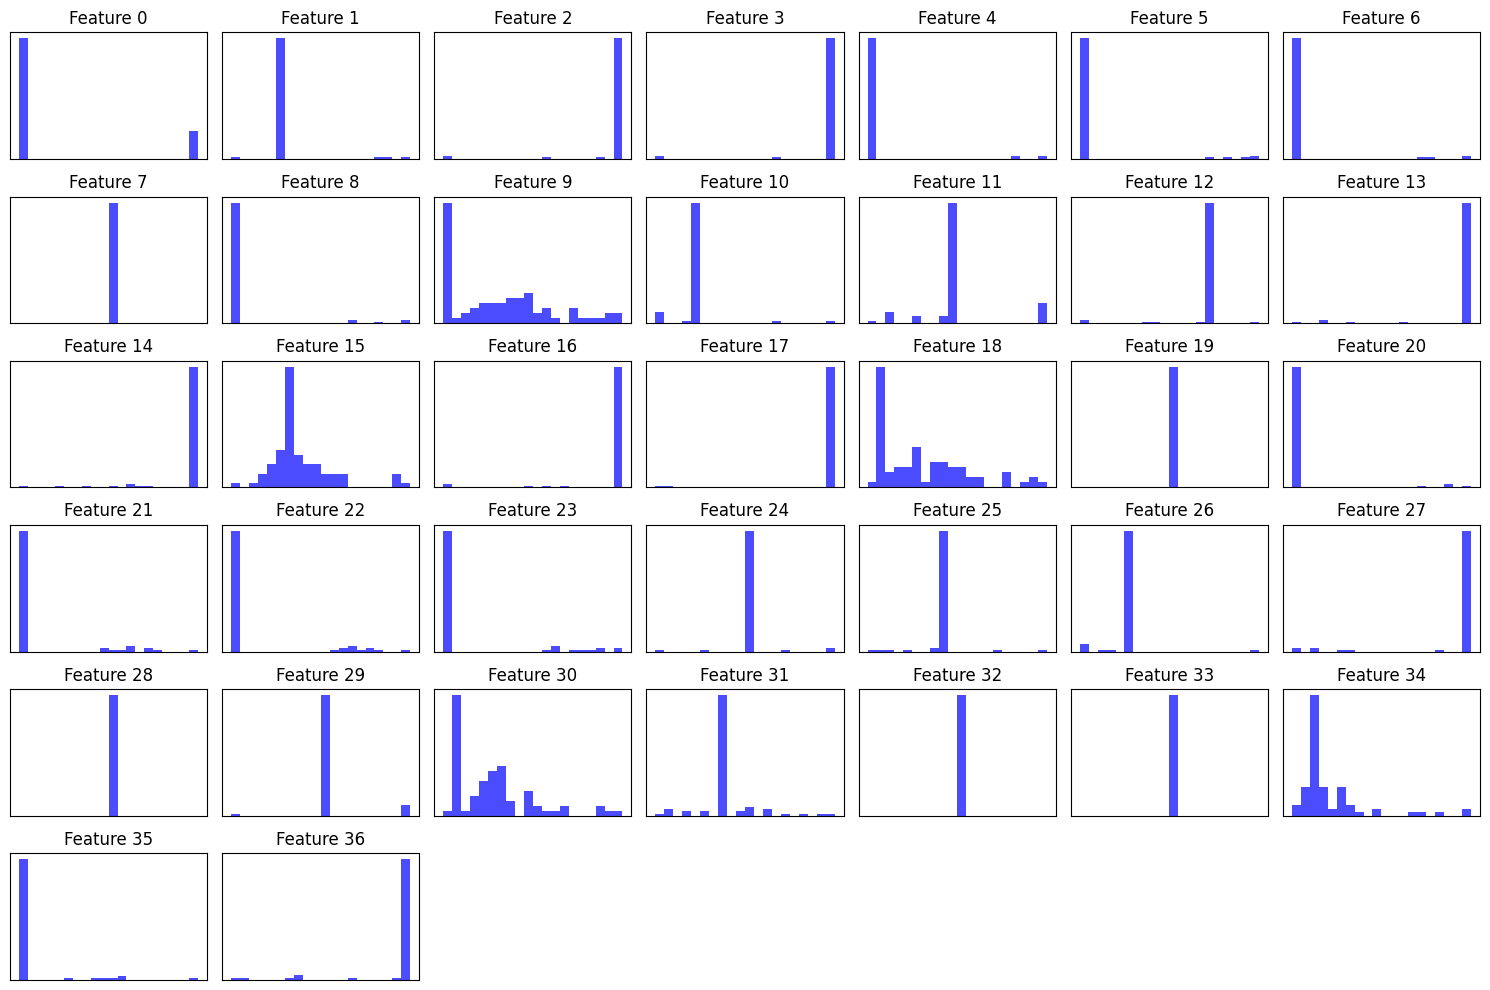

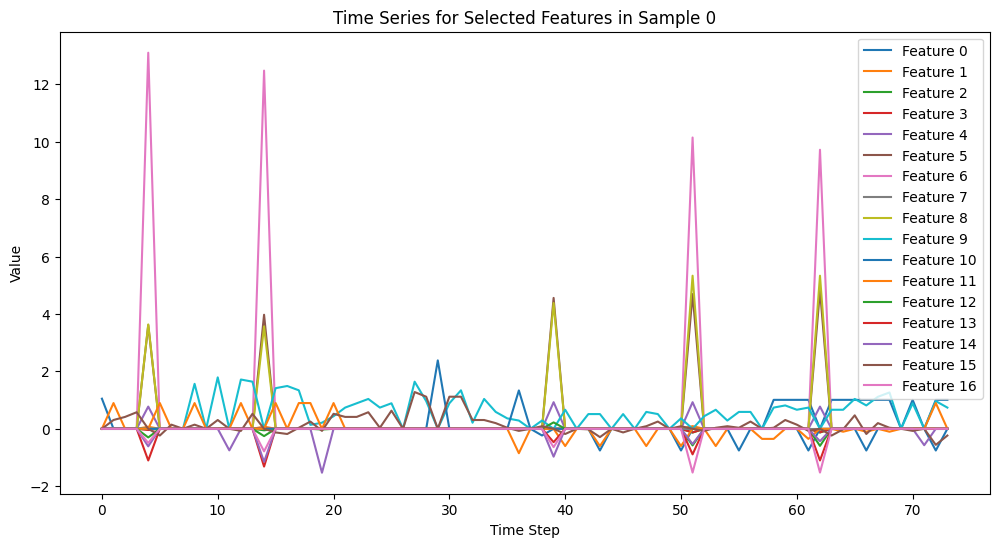

In [35]:
# Select a sample and extract ts_values
sample_idx = 0  # Change this to analyze other samples if needed
ts_values = train[sample_idx]['ts_values']

# Convert ts_values to a DataFrame for easier analysis
df_ts_values = pd.DataFrame(ts_values, columns=[f"Feature_{i}" for i in range(ts_values.shape[1])])

# 1. Basic statistics for each feature
print("Basic Statistics for Each Feature:")
feature_stats = df_ts_values.describe()
print(feature_stats)

# 2. Missing data analysis (assuming 0 as missing indicator)
missing_percentage = (df_ts_values == 0).mean() * 100  # Adjust if NaNs are used for missing values
print("\nMissing Data Percentage per Feature (assuming 0 is missing):")
print(missing_percentage)

# Plot missing data percentage for each feature
plt.figure(figsize=(12, 5))
missing_percentage.plot(kind='bar', color='orange')
plt.title("Percentage of Missing Data per Feature (assuming 0 is missing)")
plt.xlabel("Feature Index")
plt.ylabel("Missing Percentage (%)")
plt.show()

# 3. Distribution analysis
plt.figure(figsize=(15, 10))
for i in range(ts_values.shape[1]):
    plt.subplot(6, 7, i + 1)  # Adjust rows/columns if needed for better visualization
    plt.hist(df_ts_values[f"Feature_{i}"], bins=20, color='blue', alpha=0.7)
    plt.title(f"Feature {i}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# 4. Trend analysis over time for selected features
selected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]  # Change as needed to visualize other features
plt.figure(figsize=(12, 6))
for feature in selected_features:
    plt.plot(df_ts_values[f"Feature_{feature}"], label=f"Feature {feature}")
plt.title(f"Time Series for Selected Features in Sample {sample_idx}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

## Visualization of ts_indicator

Overall missing value percentage: 84.40%


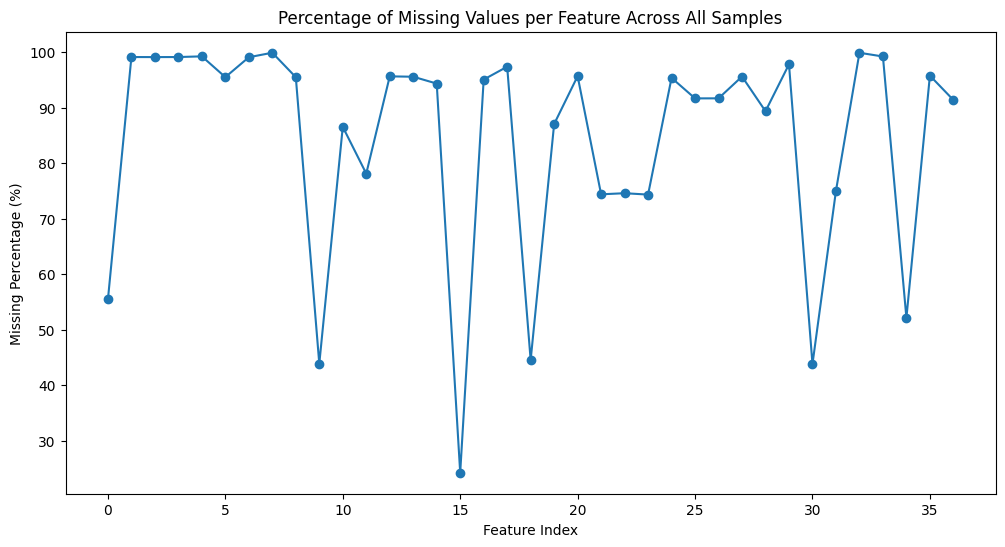

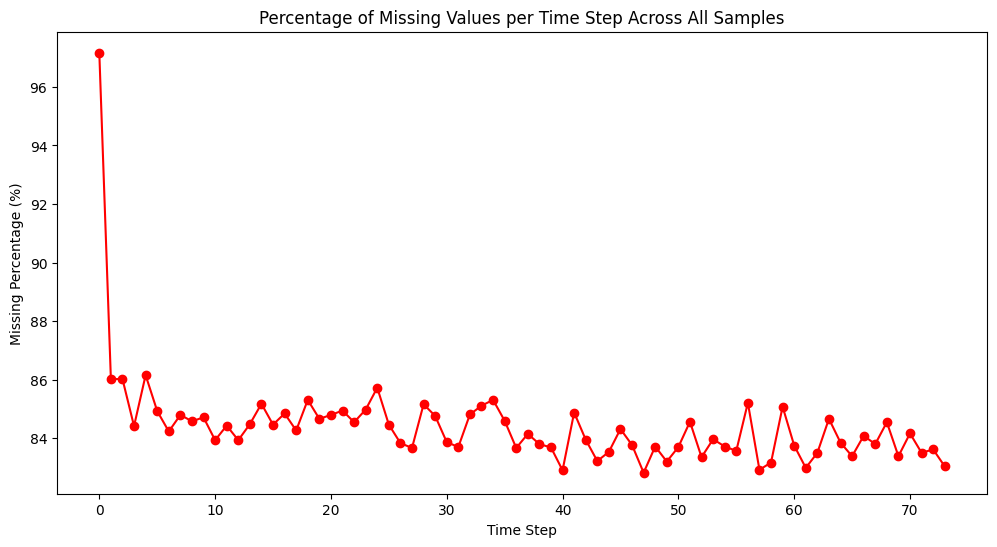

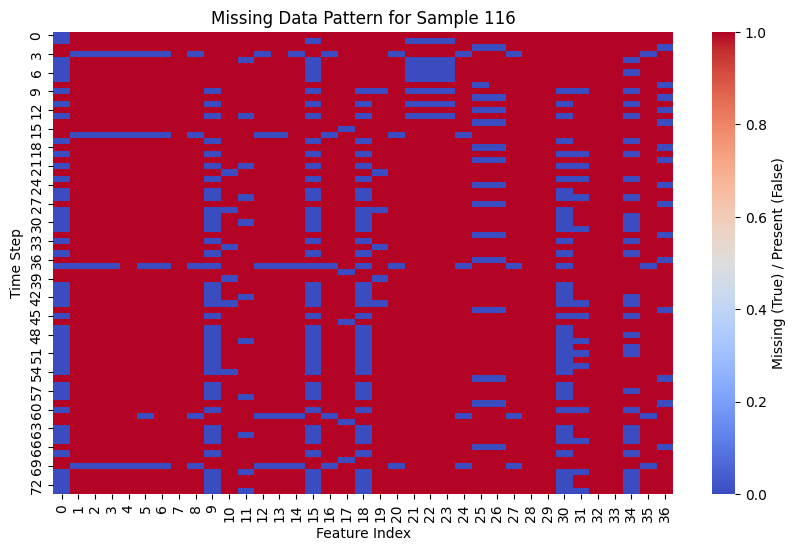

In [28]:
# Filter `ts_indicators` for samples with consistent shape (74, 37)
target_shape = (74, 37)
filtered_ts_indicators = [sample['ts_indicators'] for sample in train if sample['ts_indicators'].shape == target_shape]

# 1. Overall missing value percentage
total_values = np.prod(target_shape) * len(filtered_ts_indicators)
total_present = sum(indicator.sum() for indicator in filtered_ts_indicators)
total_missing_percentage = 100 * (1 - total_present / total_values)
print(f"Overall missing value percentage: {total_missing_percentage:.2f}%")

# 2. Percentage of missing values per feature across all samples
feature_missing_percentage = np.mean([1 - indicator.mean(axis=0) for indicator in filtered_ts_indicators], axis=0) * 100
plt.figure(figsize=(12, 6))
plt.plot(feature_missing_percentage, marker='o')
plt.title("Percentage of Missing Values per Feature Across All Samples")
plt.xlabel("Feature Index")
plt.ylabel("Missing Percentage (%)")
plt.show()

# 3. Percentage of missing values per time step across all samples
time_step_missing_percentage = np.mean([1 - indicator.mean(axis=1) for indicator in filtered_ts_indicators], axis=0) * 100
plt.figure(figsize=(12, 6))
plt.plot(time_step_missing_percentage, marker='o', color='red')
plt.title("Percentage of Missing Values per Time Step Across All Samples")
plt.xlabel("Time Step")
plt.ylabel("Missing Percentage (%)")
plt.show()

# 4. Heatmap of missing data pattern for a sample
sample_idx = np.random.randint(len(filtered_ts_indicators))
plt.figure(figsize=(10, 6))
sns.heatmap(~filtered_ts_indicators[sample_idx], cmap="coolwarm", cbar=True, cbar_kws={'label': 'Missing (True) / Present (False)'})
plt.title(f"Missing Data Pattern for Sample {sample_idx}")
plt.xlabel("Feature Index")
plt.ylabel("Time Step")
plt.show()

## Visualization of ts_times

Basic Statistics of ts_times:
Minimum time: 0.0
Maximum time: 47.18333435058594
Mean time: 22.74684715270996
Standard deviation of time: 13.56053352355957

Statistics of Time Step Differences:
Mean interval: 0.6463470458984375
Standard deviation of intervals: 0.3470495939254761
Minimum interval: 0.03333282470703125
Maximum interval: 1.0000019073486328


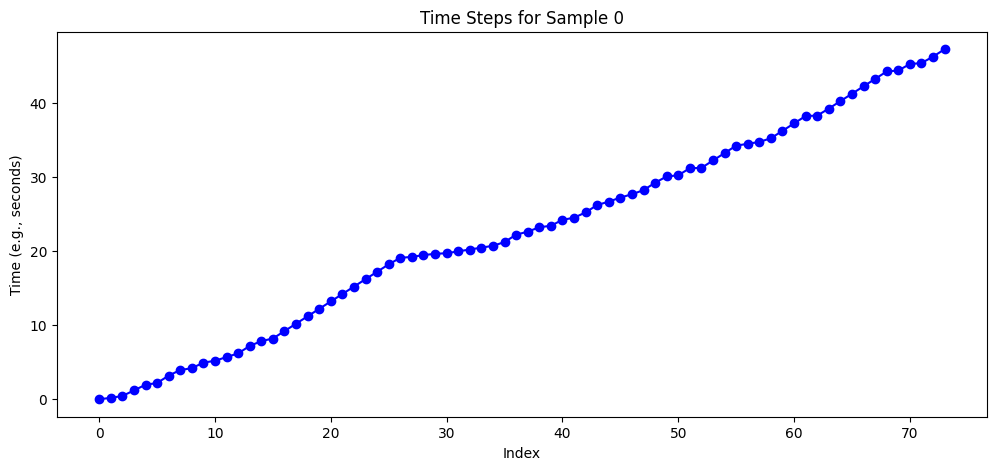

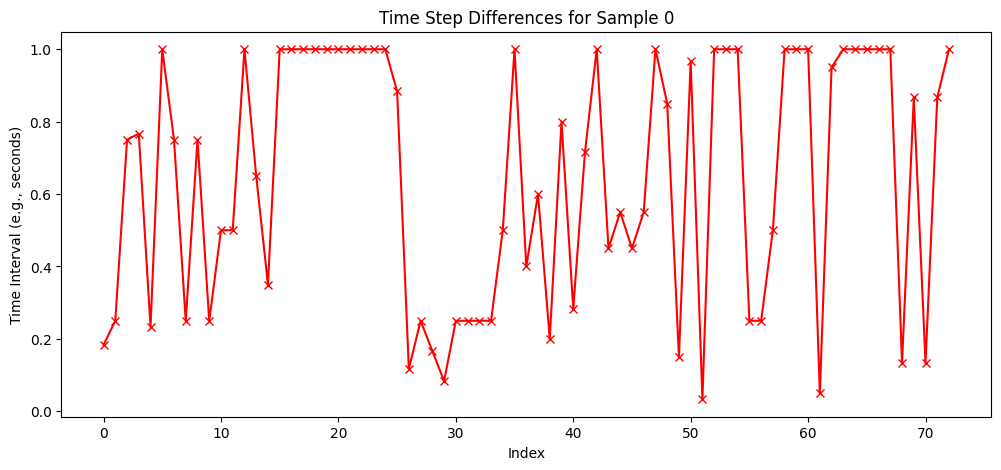

In [34]:
# Choose a sample and get its ts_times
sample_idx = 0  # Change this to analyze other samples
ts_times = train[sample_idx]['ts_times']

# 1. Basic statistics
print("Basic Statistics of ts_times:")
print(f"Minimum time: {np.min(ts_times)}")
print(f"Maximum time: {np.max(ts_times)}")
print(f"Mean time: {np.mean(ts_times)}")
print(f"Standard deviation of time: {np.std(ts_times)}")

# 2. Time step differences
time_diffs = np.diff(ts_times)
print("\nStatistics of Time Step Differences:")
print(f"Mean interval: {np.mean(time_diffs)}")
print(f"Standard deviation of intervals: {np.std(time_diffs)}")
print(f"Minimum interval: {np.min(time_diffs)}")
print(f"Maximum interval: {np.max(time_diffs)}")

# 3. Visualizations

# Plotting the time steps to see their progression
plt.figure(figsize=(12, 5))
plt.plot(ts_times, marker='o', linestyle='-', color='b')
plt.title(f"Time Steps for Sample {sample_idx}")
plt.xlabel("Index")
plt.ylabel("Time (e.g., seconds)")
plt.show()

# Plotting time intervals to see consistency
plt.figure(figsize=(12, 5))
plt.plot(time_diffs, marker='x', linestyle='-', color='r')
plt.title(f"Time Step Differences for Sample {sample_idx}")
plt.xlabel("Index")
plt.ylabel("Time Interval (e.g., seconds)")
plt.show()

## Visualization of ts_static

Static Feature Values for the Sample:
   Static_Feature_0  Static_Feature_1  Static_Feature_2  Static_Feature_3  \
0         -1.785023               0.0               1.0          1.063986   

   Static_Feature_4  Static_Feature_5  Static_Feature_6  Static_Feature_7  
0               0.0               0.0               0.0               1.0  
Static_Feature_2 is binary: 1.0
Static_Feature_6 is binary: 0.0

Basic Statistics Across All Samples for Static Features:
       Static_Feature_0  Static_Feature_1  Static_Feature_2  Static_Feature_3  \
count       9590.000000       9590.000000       9590.000000       9590.000000   
mean          -0.000684          0.435349          0.563712         -0.000646   
std            1.000376          0.495829          0.495950          1.000041   
min           -2.896097          0.000000          0.000000         -1.041340   
25%           -0.673950          0.000000          0.000000         -1.041340   
50%            0.144735          0.000000      

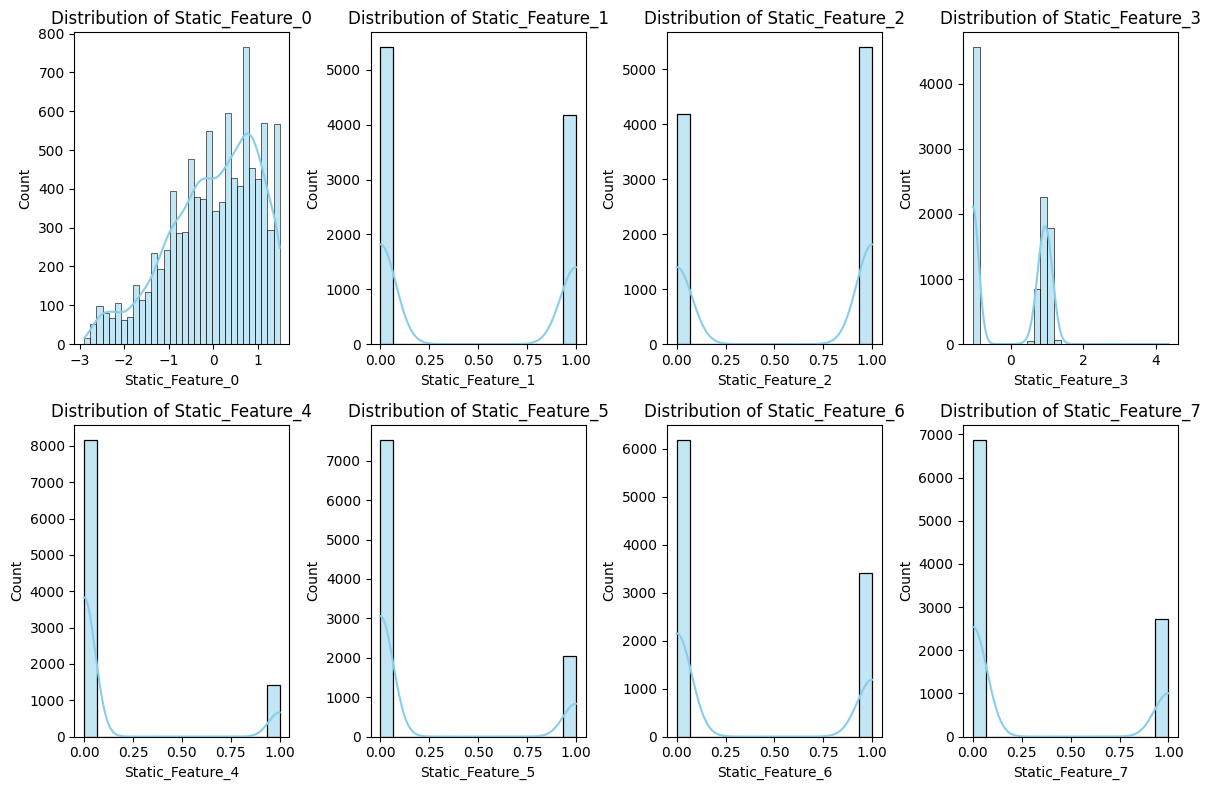

In [36]:
# Extract ts_static from a single sample
sample_idx = 0  # Change index to analyze other samples if desired
ts_static = train[sample_idx]['static']

# Convert to DataFrame for easier manipulation
df_ts_static = pd.DataFrame([ts_static], columns=[f'Static_Feature_{i}' for i in range(len(ts_static))])

# 1. Basic statistics
print("Static Feature Values for the Sample:")
print(df_ts_static)

# 2. Feature interpretation and range checking (example code if known ranges exist)
# Example: Check if a feature is binary (values in {0, 1})
binary_features = [2, 6]  # Assuming features at index 2 and 6 should be binary
for feature in binary_features:
    value = ts_static[feature]
    print(f"Static_Feature_{feature} is {'binary' if value in [0, 1] else 'not binary'}: {value}")

# 3. Distribution analysis across all samples (for a more comprehensive view)
# Extract all samples' ts_static and convert to DataFrame
all_static_features = np.array([sample['static'] for sample in train])  # Shape: (num_samples, 8)
df_all_static = pd.DataFrame(all_static_features, columns=[f'Static_Feature_{i}' for i in range(all_static_features.shape[1])])

# Overall statistics across all samples
print("\nBasic Statistics Across All Samples for Static Features:")
print(df_all_static.describe())

# Plot distributions of static features across all samples
plt.figure(figsize=(12, 8))
for i, column in enumerate(df_all_static.columns):
    plt.subplot(2, 4, i + 1)  # Assuming 8 features, adjust subplot layout as needed
    sns.histplot(df_all_static[column], kde=True, color='skyblue')
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

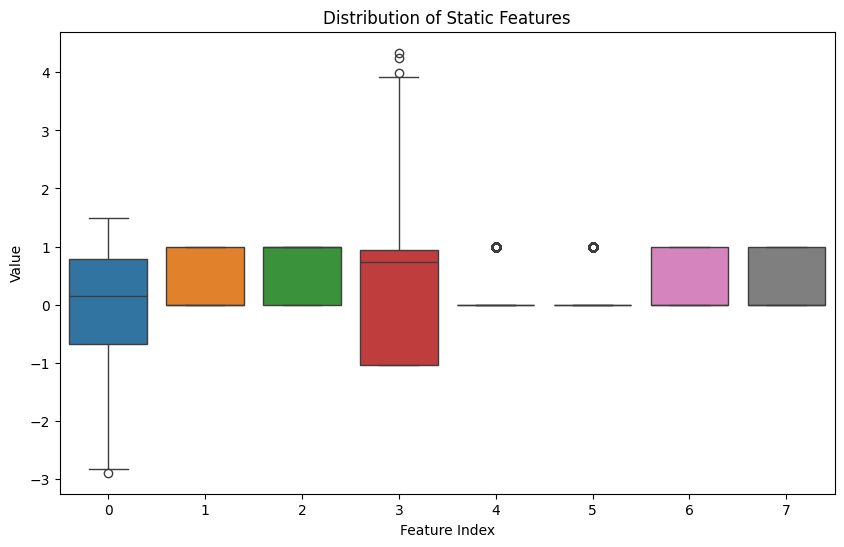

In [106]:
# 6. Static features distribution
static_data = np.array([sample['static'] for sample in train])  # Shape: (num_samples, 8)
plt.figure(figsize=(10, 6))
sns.boxplot(data=static_data)
plt.title("Distribution of Static Features")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.show()

## Measure labels

In [32]:
# 7. Labels distribution
from collections import Counter
labels = np.array([sample['labels'] for sample in train])
label_counts = Counter(labels)
print("Class distribution of labels:", label_counts)

Class distribution of labels: Counter({np.int64(0): 8248, np.int64(1): 1342})


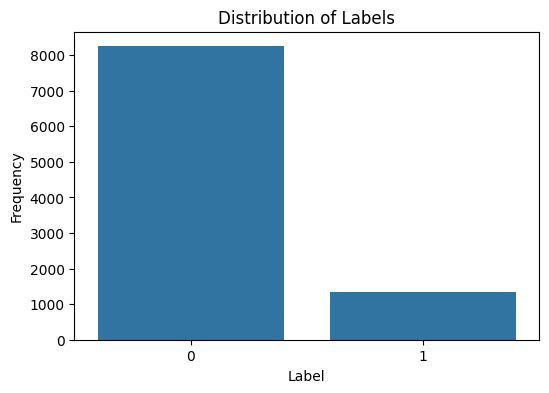

In [33]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()